In [47]:

#@title The MIT License (MIT)
#
# Copyright (c) 2024 Eric dos Santos.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.


# Style Transfer with Neural Networks  

This notebook implements the **Neural Style Transfer** (*NST*) technique, which allows combining the structure of a content image with the artistic appearance of a style image. The approach is based on the **VGG19** model, a pre-trained convolutional neural network, to extract and manipulate features from both images.  

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ericshantos/neural_style_transfer/blob/main/working_with_style_transfer.ipynb
"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/ericshantos/neural_style_transfer/blob/main/working_with_style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View the code on GitHub</a>
  </td>
</table>

In [ ]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms, models
import torch.optim as optim

## Loading VGG19

The VGG19 model is divided into two parts:  

- `vgg19.features`, which stores all convolutional and pooling layers;  
- `vgg19.classifier`, the three final classification layers.  

For the purpose of this project, it will be need to load the `features` part and "freeze" the model weights.

In [ ]:
# Load the vgg19 pre-trained model
vgg = models.vgg19(pretrained=True).features

# Freezes the convutional layers
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");

## Loading the images

Just below, there are auxiliary functions to load all types of images at any size.

In [ ]:
def load_image(img_path: str, max_size: int = 400, shape: tuple = None) -> torch.Tensor:
  """
  Loads, resizes and normalizes an image, returning it as a tensor.
  """

  image = Image.open(img_path).convert('RGB')
  size = max_size if max(image.size) > max_size else max(image.size)

  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])

  return in_transform(image)[:3, :, :].unsqueeze(0)

I then load the images and force the style image to be the same size as the content image.

Download the necessary content:

In [ ]:
!wget -O content.jpg https://blog.columbiasportswear.com.br/wp-content/uploads/2022/06/drastosa_columbia_image_852.jpeg
!wget -O style.jpg https://i0.wp.com/becodaspalavras.com/wp-content/uploads/2020/01/impressionismo-e1587477862805.jpg?fit=800%2C523&ssl=1

--2025-02-22 17:24:47--  https://blog.columbiasportswear.com.br/wp-content/uploads/2022/06/drastosa_columbia_image_852.jpeg
Resolving blog.columbiasportswear.com.br (blog.columbiasportswear.com.br)... 187.1.136.149
Connecting to blog.columbiasportswear.com.br (blog.columbiasportswear.com.br)|187.1.136.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412561 (403K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>] 402.89K   843KB/s    in 0.5s    

2025-02-22 17:24:49 (843 KB/s) - ‘content.jpg’ saved [412561/412561]

--2025-02-22 17:24:49--  https://i0.wp.com/becodaspalavras.com/wp-content/uploads/2020/01/impressionismo-e1587477862805.jpg?fit=800%2C523
Resolving i0.wp.com (i0.wp.com)... 192.0.77.2
Connecting to i0.wp.com (i0.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131153 (128K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>] 128.08K  --.

In [ ]:
# Upload image content and style
content = load_image('content.jpg').to(device)

# Reshape style to match content
style = load_image('style.jpg', shape=content.shape[-2:]).to(device)

In [ ]:
def im_convert(tensor: torch.Tensor) -> np.ndarray:
  """
  Converts a tensor to a NumPy image (H, W, C) with values ​​in the range [0, 1].
  """

  image = tensor.to("cpu").clone().detach().numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  return image.clip(0, 1)

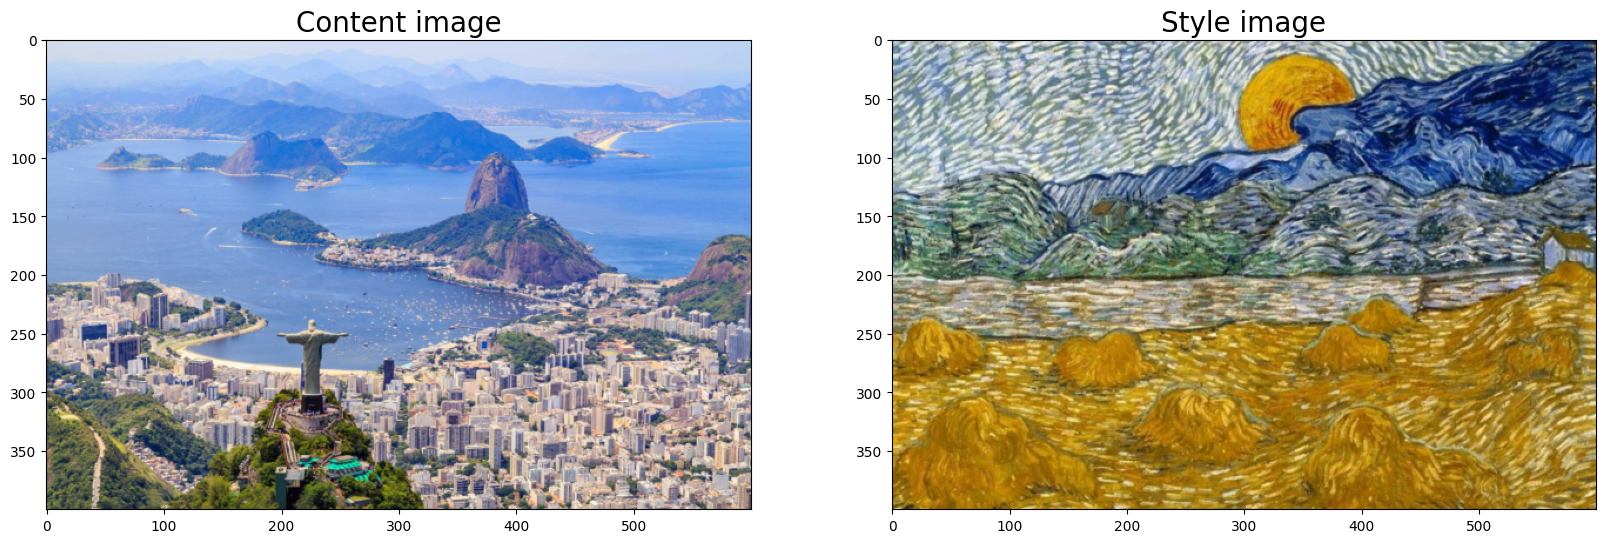

In [ ]:
# Image display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style side by side
ax1.imshow(im_convert(content))
ax1.set_title("Content image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style image", fontsize = 20)
plt.show()

## VGG19 Layer

To obtain the content and style representations of an image, it will be necessary to pass the image through the VGG19 network until it reaches the desired layer. The aim is to obtain the characteristics of both images to perform the transposition.

In [ ]:
# Print of the VGG19 model, showing the network layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and style features

In this step, I will use mappings from the layer names found in the article to the *content representations* and *style representations*.

In [ ]:

def get_features(image: torch.Tensor, model: torch.nn.Module, layers=None) -> dict:
  """
  Extracts image features in specific VGG19 layers.
  """

  if layers is None:
    layers = {
      "0": "conv1_1",
      "5": "conv2_1",
      "10": "conv3_1",
      "19": "conv4_1",
      "21": "conv4_2",
      "28": "conv5_1",
    }

  features = {}
  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x



   return features

## Gram Matrix

The **Gram matrix** measures how the different channels of an image (or convolutional layer) are related to each other. It's like calculating which texture patterns appear together in the image.

In style transfer, we use this matrix to capture the texture of the style image and apply it to the content image.

In [ ]:
def gram_matrix(tensor: torch.Tensor) -> torch.Tensor:
  """
  Calculates the Gram matrix of a feature tensor.

    Parameters:
    -----------
    tensor : torch.Tensor
      A 4D tensor of shape (batch_size, depth, height, width), where:
        - batch_size (_) → Ignored as each image is processed individually.
        -depth (d) → Number of channels in the convolutional layer.
        - height (h) → Feature map height.
        - width (w) → Feature map width.

    Return:
    --------
    gram : torch.Tensor
      A 2D Gram matrix of shape (d, d), where each value represents the
      relationship between the channels of the convolutional layer.
  """
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h * w)
  gram = torch.mm(tensor, tensor.t())

  return gram

## All together and mixed

Once I already have the auxiliary functions for feature extraction, as well as the calculation for each Gram matrix of the convulsion layers, I put everything together for the next step:

In [ ]:
# Gets representations of images
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculates the Gram matrix for each style layer
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Creating the target image
target = content.clone().requires_grad_(True).to(device)

## Loss and weight

In **Neural Style Transfer (NST)**, the weights determine how much the final image will be influenced by the original content and the applied style.  

The **individual weights** of the layers define the importance of different levels of style detail. Early layers capture finer textures and are given greater weight, while deeper layers capture global patterns and have less influence. This adjustment ensures that the final image preserves essential elements of the style without losing visual coherence.  

**Global weights** control the balance between content and style. Content is given a lower weight, ensuring that the original structure of the image is maintained, while style is given a much greater weight, forcing the image to visually transform to reflect the desired stylistic characteristics.

In [ ]:
# Weights for each layer
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e10  # beta

## Updating goals and calculating losses

Total loss:  177372348416.0


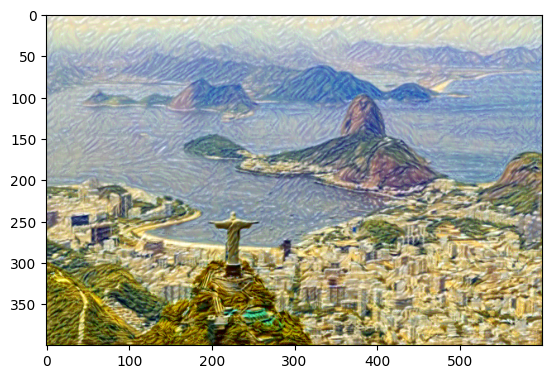

Total loss:  64261857280.0


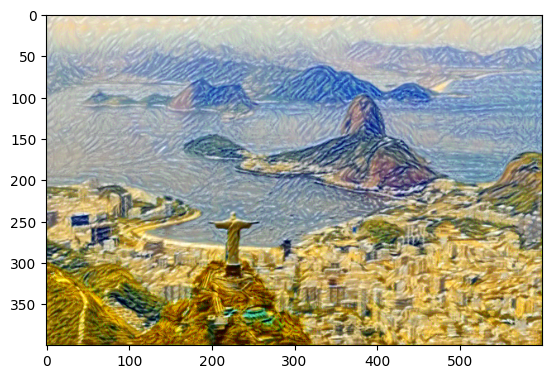

Total loss:  31060938752.0


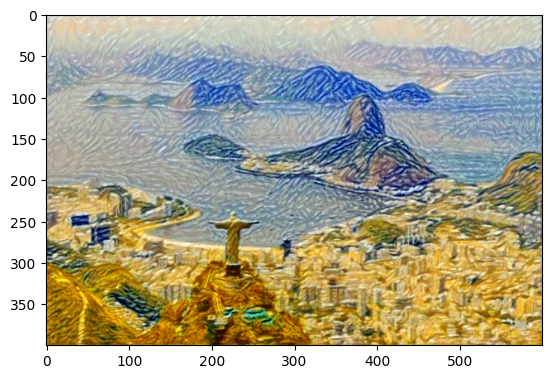

Total loss:  18842398720.0


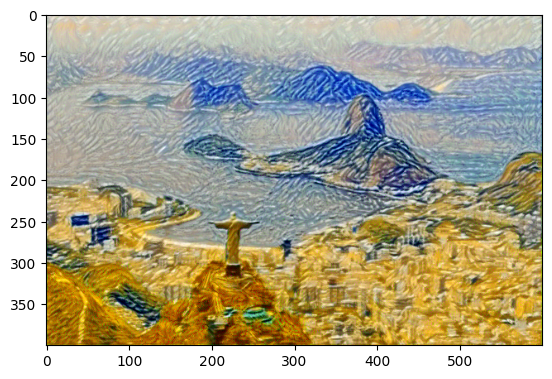

Total loss:  12711237632.0


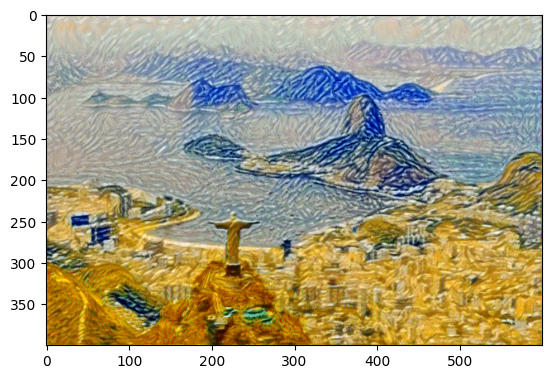

In [ ]:
# Iteration hyperparameters
optimizer = optim.Adam([target], lr=0.03)
steps = 350

# To display the target image, intermittently
show_every = steps // 5

for ii in range(1, steps+1):

    # Extracts features from the target image
    target_features = get_features(target, vgg)

    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Loss of style
    # Initialize with value 0
    style_loss = 0

    # Adds the Gram matrix loss of each layer
    for layer in style_weights:

        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape

        # Extracts representations from the style image
        style_gram = style_grams[layer]

        # The loss of each layer, with the appropriate weights
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        # Adds to the loss of style
        style_loss += layer_style_loss / (d * h * w)

    # Calculate total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Update the target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Result

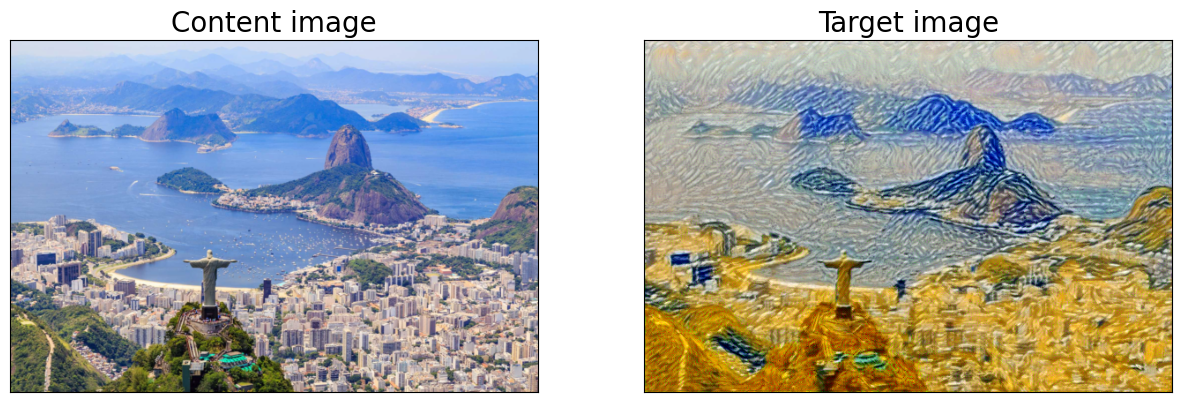

In [ ]:
# Final content display, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(im_convert(content))
ax1.set_title("Content image", fontsize = 20)
ax2.imshow(im_convert(target))
ax2.set_title("Target image", fontsize = 20)
ax1.grid(False)
ax2.grid(False)

# Hide axes ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()